<a href="https://colab.research.google.com/github/deayalar/deeplearning_unitn/blob/triplet/DL_Project_wandb_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Course Assignment 20/21
University of Trento

---
This notebook contains the implementation of the Deep Learning course assignment at the University of Trento. 

Given the person re-identification dataset Market1501, the assignment is composed by two task

1.   Task 1 - Classification Task: The dataset contains a csv file with attributes annotations. Each image of the training set is labeled with 27 attributes that includes age, hair length, gender, length of lower/upper-body clothing, wearing hat, anong others, more details [here](https://github.com/vana77/Market-1501_Attribute). The task consists on predicting such attributes.
2.   Task 2 - Person Re-Identification Task: This is an image retrieval task, that returns a list of images that corresponds to the same identity of a given query image.

The main framework used in this implementation is PyTorch.

## 1. Download Dataset
The dataset is stored in an AWS S3 bucket. Running this cell, it will be downloaded and unzipped in the _dataset_ folder. It contains the following structure.

*   _train_: Contains the annotated images with identity and attributes. The validation set will be extracted from this folder
*   _test_: This folder contains unlabeled images in which the final model will perform predictions
* _queries_: This folder contains the queries for the person re-identification task
* _annotations_train.csv_: This csv file contains the annotations for the 27 attributes classification task


In [1]:
!wget https://market1501.s3-us-west-2.amazonaws.com/dataset.zip
!unzip -q dataset.zip -d dataset

--2021-07-09 14:14:35--  https://market1501.s3-us-west-2.amazonaws.com/dataset.zip
Resolving market1501.s3-us-west-2.amazonaws.com (market1501.s3-us-west-2.amazonaws.com)... 52.218.160.37
Connecting to market1501.s3-us-west-2.amazonaws.com (market1501.s3-us-west-2.amazonaws.com)|52.218.160.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82925180 (79M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  79.08M  64.3MB/s    in 1.2s    

2021-07-09 14:14:37 (64.3 MB/s) - ‘dataset.zip’ saved [82925180/82925180]



## 2. Download Source Code
The source code is hosted in this Github repository: https://github.com/deayalar/deeplearning_unitn Running the following cells will clone the repository.

In [2]:
!rm -rf /content/deeplearning_unitn
!git clone https://github.com/deayalar/deeplearning_unitn.git

Cloning into 'deeplearning_unitn'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 302 (delta 165), reused 158 (delta 71), pack-reused 0
Receiving objects: 100% (302/302), 11.30 MiB | 6.16 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [3]:
%cd /content/deeplearning_unitn
!git fetch origin 
!git checkout triplet

/content/deeplearning_unitn
Already on 'triplet'
Your branch is up to date with 'origin/triplet'.


Check the GPU assigned by Google Colab

In [4]:
!nvidia-smi

Fri Jul  9 14:14:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 3. Configuration
The configuration of each experiment is defined by the following dictionary.

**wandb**: Boolean - Save the experiment in weights and biases

**device**: Select an specific device "auto" to select automatically between cpu and cuda:0

**train_root**, test_root, queries_root, attributes_file: Dataset paths

**backbone**: Backbone architecture among "resnet18", "resnet34", "resnet50"

**split.full_training_size**: Split proportions of the training set

**compose**: Contains parameters for the dataset transformations

**epochs**: Number of epochs of the training

**training_batch_size**: Batch size during training time

**validation_batch_size**: Batch size for testing and validation

**learning_rate**: Defines the learning rate for the entire architecture

**weight_decay**: Regularization term hyperparameter

**momentum**: Momentum of the SGD optimizer

**test_before_training**: Boolean flag to perform test on validation set before training

**test_after_each_epoch**: Boolean flag to perform testing on validation set after each epoch

**mAP_rank**: Top K results for the mAP computation



In [5]:
config = dict(
    wandb = False,
    device = "auto",
    train_root = "/content/dataset/train",
    test_root = "/content/dataset/test", 
    queries_root = "/content/dataset/queries",
    attributes_file = "/content/dataset/annotations_train.csv",
    backbone = "resnet34",
    split = dict(
        full_training_size = 0.8
    ),
    compose = dict(
        resize_h = 224,
        resize_w = 224
    ),
    epochs=20,
    training_batch_size=128,
    validation_batch_size=32,
    learning_rate=0.01,
    weight_decay=0.000001, 
    momentum=0.9,
    test_before_training=True,
    test_after_each_epoch=True,
    mAP_rank=15)

In [6]:
%cd /content/deeplearning_unitn

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm

import cost_functions
from evaluation import Evaluator
from datasets.reid_dataset import Market1501
from cost_functions import OverallLossWrapper
from utils.split_data import ValidationSplitter, TrainingSplitter
from models.reid_model import FinetunedModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if config["device"] == "auto":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = config["device"]
print(device)

/content/deeplearning_unitn
cuda:0


In [7]:
!pip install wandb -q
import wandb
if config["wandb"]:
  wandb.login()

     |████████████████████████████████| 1.8MB 7.4MB/s 
     |████████████████████████████████| 174kB 52.5MB/s 
     |████████████████████████████████| 143kB 55.8MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 


## 4. Training

In [8]:
def model_pipeline(hyperparameters):
    """
    This function corresponds to the basic pipeline of all tested models
    0) Split data
    1) Setup based on the configuration
    2) Train the model
    3) Test performance
    """
    config = hyperparameters
    if config["wandb"]:
      wandb.init(entity="dl_unitn", project="dl_project", config=hyperparameters)
      config = wandb.config
    print(config)
    
    train_set, val_set, val_queries = split_data(config)
    
    model, train_loader, val_loader, val_queries_loader, criterion, optimizer = setup(train_set, val_set, val_queries, config)
    id_ground_truth_dict = build_ground_truth(val_set, val_queries)

    print("Using "+ config["backbone"] + " as backbone")
    if config["test_before_training"]:
      test(model, val_loader, val_queries_loader, id_ground_truth_dict, config)

    train(model, train_loader, val_loader, criterion, optimizer, val_queries_loader, id_ground_truth_dict, config)

    test(model, val_loader, val_queries_loader, id_ground_truth_dict, config, save_model=True)

    return model

In [10]:
def build_ground_truth(val_set, val_queries):
    """
    This function builds the identity ground truth dictionary used to cmpute the mAP
    """
    values = []
    for q in val_queries:
        matches = []
        for idx_v, v in enumerate(val_set):
            if v.split("_")[0] == q.split("_")[0]:
                matches.append(idx_v)
        value = set(matches)
        values.append(value)
        
    ground_truth_dict = dict(zip(list(range(0, len(val_queries))), values))
    return ground_truth_dict


### 4.1 Model Architecture
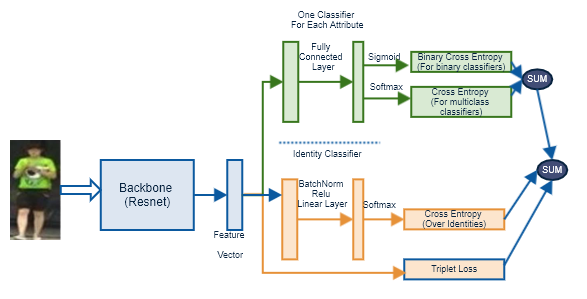

In [11]:
def split_data(config):
    """
    Returns a list with the names of the images in each set. 
    Note: The identities in the training set and the validation set are different
    """
    splitter = ValidationSplitter(train_root=config["train_root"], 
                                  test_root=config["test_root"], 
                                  queries_root=config["queries_root"])
    train_set, val_set, val_queries = splitter.split(train_size=config["split"]["full_training_size"],
                                                     random_seed=42)
    return train_set, val_set, val_queries

def setup(train_set, val_set, val_queries, config):
    """
    This function creates the setup of the experiment
    It creates the train/validation custom pytorch datasets (Market1501) and dataloaders, 
    It creates the instance of the model, loss function and optimizer
    """
    #Create pytorch Datasets
    train_composed = transforms.Compose([ transforms.Resize((config["compose"]["resize_h"], 
                                                      config["compose"]["resize_w"])),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225]),
                                          transforms.RandomErasing(p=0.6)])
    
    val_composed = transforms.Compose([transforms.Resize((config["compose"]["resize_h"], 
                                                      config["compose"]["resize_w"])),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225])])
    
    train_dataset = Market1501(root_dir=config["train_root"],
                            attributes_file=config["attributes_file"],
                            images_list=train_set,
                            transform=train_composed)
                            
    val_dataset = Market1501(root_dir=config["train_root"],
                         attributes_file=config["attributes_file"],
                         images_list=val_set,
                         transform=val_composed)

    val_queries_dataset = Market1501(root_dir=config["train_root"],
                         attributes_file=config["attributes_file"],
                         images_list=val_queries,
                         transform=val_composed)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=config["training_batch_size"], 
                                               shuffle=True, 
                                               num_workers=2,
                                               drop_last=True)
                                               
    val_loader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=config["validation_batch_size"], 
                                             shuffle=False, 
                                             num_workers=2)

    val_queries_loader = torch.utils.data.DataLoader(val_queries_dataset, 
                                             batch_size=config["validation_batch_size"],
                                             shuffle=False, 
                                             num_workers=2)

    attr_len = len(train_dataset[0][2]) #Number of attributes in the csv: 27
    print(f"Number of attributes: {attr_len}")

    model = FinetunedModel(architecture=config["backbone"],
                           n_identities=len(train_dataset.unique_identities)).to(device)

    #This is a combination of the attributes classification loss and the triplet loss for identification
    criterion = OverallLossWrapper()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=config["learning_rate"], 
                                weight_decay=config["weight_decay"], 
                                momentum=config["momentum"])
    
    return model, train_loader, val_loader, val_queries_loader, criterion, optimizer

In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, val_queries_loader, id_ground_truth_dict, config):
    """
    This function contains the training loop and checking of validation performance after each epoch
    """
    print("Training...")
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    if config["wandb"]:
         wandb.watch(model, criterion, log="all", log_freq=10)
    
    # Run training and track with wandb
    total_batches = len(train_loader) * config["epochs"]
    example_ct = 0  # number of seen examples
    batch_ct = 0

    for epoch in tqdm(range(config["epochs"])):
        model.train()
        for batch_idx, (inputs, identity, attributes) in enumerate(train_loader):
            loss = train_batch(inputs, identity, attributes, model, optimizer, criterion)

            example_ct +=  len(inputs)
            batch_ct += 1

            if ((batch_ct + 1) % 50) == 0:
                train_log(loss, example_ct, epoch)

        if config["test_after_each_epoch"]:
          test(model, val_loader, val_queries_loader, id_ground_truth_dict, config)


def train_batch(inputs, identity, attributes, model, optimizer, criterion):
    inputs = inputs.to(device)
    attributes = attributes.to(device)
    
    # Forward pass
    output_attrs, output_ids, output_features = model(inputs)

    # Apply the loss
    loss = criterion(output_attrs, attributes, output_features, identity, output_ids)
    
    optimizer.zero_grad()
    # Backward pass
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [13]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)
    if config["wandb"]:
        wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Epoch {epoch}: Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

## 5. Testing

This section contains the code to compute the mAP and attributes performance on the validation set.

### 5.1 Re-identification evaluation


In [14]:
def get_features_from_loader(model, loader):
    """
    This function uses the model to compute all the vector representation (features) of all the examples given in the loader
    """
    model.eval()
    with torch.no_grad():
        all_features = torch.zeros(len(loader.dataset), model.feature_size)
        for batch_idx, (inputs, ids, attr) in enumerate(tqdm(loader)):
                inputs = inputs.to(device)
                _, _, features = model(inputs)
                for in_batch, f in enumerate(features):
                    all_features[(batch_idx * loader.batch_size) + in_batch] = f
        return all_features

def get_topK_results(model, gallery_loader, queries_loader, config):
    """
    This function returns the closest k features representation. It computes the features from the loader,
    computes the similarity matrix, sort it and select the top k elements
    """
    with torch.no_grad():
        
        # Compute the features for queries and gallery
        print("Computing gallery features...")
        gallery_features = get_features_from_loader(model, gallery_loader)
        print("Computing query features...")
        query_features = get_features_from_loader(model, queries_loader)
        
        # Build the cosine similarity matrix between the all the queries and all the elements in gallery
        print("Computing cosine similarities...")
        sims_matrix = torch.empty(query_features.size()[0], gallery_features.size()[0])
        for idx, q in enumerate(query_features):
            sims_matrix[idx] = F.cosine_similarity(q, gallery_features, dim=-1)
        
        print("Similarity matrix shape: " + str(sims_matrix.size()))
        sorted_index = torch.argsort(sims_matrix, dim=1, descending=True)
        top_k = sorted_index.narrow_copy(dim=1, start=0, length=config["mAP_rank"])
        return top_k

def test_mAP(model, gallery_loader, queries_loader, ground_truth_dict, config, save_model=False):
    """
    This function returns the mAP performance of a given model 
    Params:
    model: model to be evaluated
    gallery: tensor that contains the feature representations of the target images in validation or test set
    queries: tensor that contains feature representations of the queries
    rank: top number of elements to retrieve

    Returns:
    mAP performance of the model
    """
    top_k = get_topK_results(model, gallery_loader, queries_loader, config)
    #Build the dictionary to compute the mAP
    predictions_dict = {idx:  r for idx, r in enumerate(top_k.tolist())}
    mAP = Evaluator.evaluate_map(predictions_dict, ground_truth_dict)
    
    print(f"mAP: {mAP}")
    if config["wandb"]:
        wandb.log({"mAP": mAP})

### 5.2 Attributes classification evaluation

In [15]:
def get_attributes_from_loader(model, loader):
    """
    Computes the attributes prediction for all the examples in the loader
    """
    model.eval()

    all_predictions = np.empty(shape=[0, 27], dtype=np.byte)
    all_attrs = np.empty(shape=[0, 27], dtype=np.byte)

    with torch.no_grad():
        for batch_idx, (inputs, ids, attr) in enumerate(tqdm(loader)):
                inputs = inputs.to(device)
                outputs, _, _ = model(inputs)
                predictions = torch.empty(attr.size()[1], attr.size()[0])
                for attr_idx, output in enumerate(outputs):
                    if output.size()[1] == 1: #If the output is binary
                        pred = torch.round(torch.squeeze(output, 1))
                    else: #Otherwise it is multiclass
                        pred = torch.argmax(output, dim=1)
                    predictions[attr_idx] = pred

                predictions = torch.transpose(predictions, 0, 1).cpu().numpy()
                attr = attr.cpu().numpy()

                all_predictions = np.append(all_predictions, predictions, axis=0)
                all_attrs = np.append(all_attrs, attr, axis=0)
        return all_predictions, all_attrs

def test_attributes(model, loader, config):
    """
    Compute the metrics for the attributes classification task
    """
    print("Computing attributes...")
    predictions, attr = get_attributes_from_loader(model, loader)
    print("pred shape: ", predictions.shape)
    print("attr shape: ", attr.shape)

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []

    for i in range(0, predictions.shape[1]):
        y_true, y_pred = attr[:, i], predictions[:, i]
        accuracy_list.append(accuracy_score(y_true, y_pred))
        if i == 0: #If it is age
            precision_list.append(precision_score(y_true, y_pred, average='macro'))
            recall_list.append(recall_score(y_true, y_pred, average='macro'))
            f1_score_list.append(f1_score(y_true, y_pred, average='macro'))
        else:
            precision_list.append(precision_score(y_true, y_pred))
            recall_list.append(recall_score(y_true, y_pred))
            f1_score_list.append(f1_score(y_true, y_pred))

    average_acc = np.mean(accuracy_list)
    average_precision = np.mean(precision_list)
    average_recall = np.mean(recall_list)
    average_f1score = np.mean(f1_score_list)

    print("accuracy_list: ", accuracy_list)
    print("precision_list: ", precision_list)
    print("recall_list: ", recall_list)
    print("f1_score_list: ", f1_score_list)

    print("average_acc: ", average_acc)
    print("average_precision: ", average_precision)
    print("average_recall: ", average_recall)
    print("average_f1score: ", average_f1score)

    if config["wandb"]:
            wandb.log({"accuracy_list": accuracy_list})
            wandb.log({"precision_list": precision_list})
            wandb.log({"recall_list": recall_list})
            wandb.log({"f1_score_list": f1_score_list})

            wandb.log({"average accuracy": average_acc})
            wandb.log({"average precision": average_precision})
            wandb.log({"average recall": average_recall})
            wandb.log({"average f1": average_f1score})

In [16]:
def test(model, gallery_loader, queries_loader, ground_truth_dict, config, save_model=False):
    print("Testing")
    model.eval()

    test_mAP(model, gallery_loader, queries_loader, ground_truth_dict, config)
        
    test_attributes(model, gallery_loader, config)

    if save_model :
      torch.save(model.state_dict(), "model")
      if config["wandb"]:
        wandb.save("model")

## 6. Run Training

In [17]:
model = model_pipeline(config)

{'wandb': False, 'device': 'auto', 'train_root': '/content/dataset/train', 'test_root': '/content/dataset/test', 'queries_root': '/content/dataset/queries', 'attributes_file': '/content/dataset/annotations_train.csv', 'backbone': 'resnet34', 'split': {'full_training_size': 0.8}, 'compose': {'resize_h': 224, 'resize_w': 224}, 'epochs': 20, 'training_batch_size': 128, 'validation_batch_size': 32, 'learning_rate': 0.01, 'weight_decay': 1e-06, 'momentum': 0.9, 'test_before_training': True, 'test_after_each_epoch': True, 'mAP_rank': 20}
Extract queries proportion: 0.11
Identities in train set: 600
Identities in validation set: 151
Train set size: 10351
Validation set size: 2347
Number of validation queries: 291
Number of attributes: 27


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



Backbone feature size: 512
Using resnet34 as backbone
Testing
Computing gallery features...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.09867061524733026
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.05027694929697486, 0.5990626331487005, 0.3242437153813379, 0.9062633148700469, 0.4584576054537708, 0.5274818917767362, 0.10651896037494674, 0.6429484448231785, 0.9676182360460162, 0.48828291435875587, 0.5398380911802301, 0.6893907115466553, 0.8887942053685556, 0.13123135918193438, 0.9002982530890499, 0.17213463996591394, 0.14145717937792926, 0.8900724328930549, 0.5155517682147422, 0.05581593523647209, 0.8789944610140605, 0.9015764806135492, 0.4635705155517682, 0.7132509586706434, 0.5164039198977418, 0.006391137622496805, 0.8048572645930976]
precision_list:  [0.26473897389738976, 0.24444444444444444, 0.28931404573028463, 0.08695652173913043, 0.9363295880149812, 0.531496062992126, 0.9824561403508771, 0.2761904761904762, 0.0, 0.39565627950897075, 0.08196721311475409, 0.32989690721649484, 1.0, 0.010209042294603793, 0.0, 0.08753568030447194, 0.12630208333333334, 0.0728476821192053, 0.4708171206225681, 0.048927038626609444, 

/content/deeplearning_unitn/cost_functions/__init__.py:67: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  dist.addmm_(1, -2, inputs, inputs.t())


Epoch 0: Loss after 06272 examples: 13.018
Testing
Computing gallery features...



Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.45694758518301404
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8155091606305922, 0.6923732424371538, 0.9143587558585429, 0.9373668512995313, 0.8721772475500639, 0.9139326800170431, 0.818065615679591, 0.9727311461440137, 0.78014486578611, 0.9527055815935237, 0.8551342138900724, 0.945888368129527, 0.9936088623775032, 0.9867916489135066, 0.9233063485300383, 0.9032807839795484, 0.9450362164465275, 0.8363868768640818, 0.9556881124840222, 0.9821048146570089, 0.9957392415850022, 0.9970174691095015, 0.8798466126970601, 0.8483170004260758, 0.994034938219003, 0.9586706433745207]
precision_list:  [0.2046229228802727, 0.691358024691358, 0.29473684210526313, 0.0, 0.9477351916376306, 0.8778747026169706, 0.9177377892030848, 0.7908256880733945, 0.0, 0.792191435768262, 0.7741935483870968, 0.9494949494949495, 0.7547169811320755, 0.6956521739130435, 0.9719626168224299, 0.7636363636363637, 0.7844827586206896, 0.5, 0.8977528089887641, 0.5694444444444444, 0.8571428571428571, 0.0, 0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Loss after 12672 examples: 10.793
Epoch 1: Loss after 19072 examples: 9.381
Testing
Computing gallery features...



Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.5351317022489424
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.7912228376651044, 0.6685129953131658, 0.8704729441840647, 0.9305496378355347, 0.8789944610140605, 0.9139326800170431, 0.8363868768640818, 0.9723050703025139, 0.8274392841925863, 0.9667660843630166, 0.861951427354069, 0.9556881124840222, 0.9727311461440137, 0.9855134213890072, 0.9335321687260333, 0.9105240732850447, 0.9735832978270132, 0.8862377503195569, 0.9548359608010226, 0.9816787388155092, 0.9957392415850022, 0.9974435449510013, 0.8785683851725608, 0.8696207925010652, 0.9944610140605028, 0.9531316574350235]
precision_list:  [0.2046229228802727, 0.9448275862068966, 0.379746835443038, 0.09448818897637795, 0.9700460829493087, 0.8503253796095445, 0.9184549356223176, 0.7179176755447942, 0.0, 0.7484874675885912, 0.8369565217391305, 0.926605504587156, 0.8319327731092437, 0.22972972972972974, 0.9715639810426541, 0.6480446927374302, 0.7785234899328859, 0.7768595041322314, 0.8552971576227391, 0.5392156862


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.5905465422334027
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8291435875585854, 0.6991904559011504, 0.8764380059650618, 0.9275671069450362, 0.8926288879420536, 0.9135066041755433, 0.8227524499360886, 0.9731572219855135, 0.8210481465700895, 0.9616531742650192, 0.8922028121005539, 0.9501491265445249, 0.9923306348530039, 0.9876438005965061, 0.9301235619940349, 0.9113762249680443, 0.9616531742650192, 0.8777162334895612, 0.9629314017895185, 0.9821048146570089, 0.9957392415850022, 0.9987217724755006, 0.8828291435875586, 0.8764380059650618, 0.9944610140605028, 0.9688964635705155]
precision_list:  [0.2046229228802727, 0.6953405017921147, 0.46254071661237783, 0.0761904761904762, 0.9792550683639792, 0.8463667820069204, 0.9191397849462366, 0.7949640287769785, 0.6, 0.8491271820448878, 0.8246268656716418, 0.808066759388039, 0.8372093023255814, 0.6, 0.9358974358974359, 0.7586206896551724, 0.7297297297297297, 0.5970149253731343, 0.8318219291014015, 0.5944055944055944, 0.7272


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6066338909269323
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8696207925010652, 0.7115466553046442, 0.8913506604175543, 0.9352364720920324, 0.8789944610140605, 0.9147848317000427, 0.8363868768640818, 0.9748615253515126, 0.8521516829995739, 0.9510012782275244, 0.8747337025990626, 0.9693225394120153, 0.9893481039625053, 0.9884959522795057, 0.9305496378355347, 0.9045590115040477, 0.965913932680017, 0.8828291435875586, 0.9650617809970174, 0.9893481039625053, 0.9957392415850022, 1.0, 0.850021303792075, 0.8670643374520665, 0.9944610140605028, 0.9582445675330209]
precision_list:  [0.2046229228802727, 0.8454746136865342, 0.5112781954887218, 0.3333333333333333, 0.9736720554272518, 0.8836104513064132, 0.9199655765920827, 0.7735562310030395, 0.6923076923076923, 0.8246153846153846, 0.9408284023668639, 0.8806818181818182, 0.8861788617886179, 0.4857142857142857, 0.9153225806451613, 0.6742424242424242, 0.7593984962406015, 0.6269430051813472, 0.8453085376162299, 0.77586206896


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6191503209733222
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.850021303792075, 0.6574350234341713, 0.8508734554750745, 0.9595227950575203, 0.8849595227950575, 0.9092458457605453, 0.8449083936940776, 0.974009373668513, 0.8683425649765658, 0.9603749467405198, 0.9041329356625479, 0.9663400085215168, 0.9957392415850022, 0.9821048146570089, 0.9130805283340434, 0.9002982530890499, 0.9727311461440137, 0.8078397954835961, 0.9650617809970174, 0.9919045590115041, 0.9957392415850022, 0.9970174691095015, 0.8576906689390712, 0.8372390285470814, 0.9944610140605028, 0.9633574776310183]
precision_list:  [0.2046229228802727, 0.789587852494577, 0.4170096021947874, 0.20784313725490197, 0.9743474347434743, 0.8425087108013938, 0.922808547754034, 0.7513227513227513, 0.8, 0.8799546998867497, 0.7918088737201365, 0.9081455805892548, 0.9178082191780822, 0.9375, 0.9400921658986175, 0.5101214574898786, 0.6322869955156951, 0.7338129496402878, 0.8157635467980295, 0.7051282051282052, 0.7916


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6392990002138607
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8385172560715808, 0.7025990626331488, 0.8602471239880699, 0.9608010225820196, 0.8883681295270558, 0.907967618236046, 0.8615253515125693, 0.9744354495100128, 0.8747337025990626, 0.9612270984235194, 0.887942053685556, 0.965913932680017, 0.9923306348530039, 0.9782701320835109, 0.8934810396250532, 0.9024286322965488, 0.9616531742650192, 0.8351086493395824, 0.9625053259480187, 0.9931827865360034, 0.9957392415850022, 0.9978696207925011, 0.8632296548785684, 0.8197699190455902, 0.9957392415850022, 0.9671921602045164]
precision_list:  [0.2046229228802727, 0.820855614973262, 0.4847870182555781, 0.2548262548262548, 0.9651828999559278, 0.8814472671285605, 0.9230769230769231, 0.8208269525267994, 0.6666666666666666, 0.9093078758949881, 0.8878923766816144, 0.9391480730223124, 0.8991228070175439, 0.6, 0.9840425531914894, 0.42955326460481097, 0.6523809523809524, 0.6031746031746031, 0.8622816032887975, 0.635416666666


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6364331062643661
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8606731998295697, 0.7141031103536429, 0.8875159778440562, 0.9531316574350235, 0.8896463570515551, 0.893907115466553, 0.835960801022582, 0.9714529186195143, 0.853855986365573, 0.9718789944610141, 0.8802726885385599, 0.9680443118875159, 0.9944610140605028, 0.9893481039625053, 0.9326800170430336, 0.9096719216020451, 0.9701746910950149, 0.8632296548785684, 0.9688964635705155, 0.9791222837665104, 0.9957392415850022, 0.9982956966340009, 0.8653600340860673, 0.8547081380485726, 0.9965913932680017, 0.9714529186195143]
precision_list:  [0.2046229228802727, 0.7967479674796748, 0.5212765957446809, 0.2396694214876033, 0.956787429070275, 0.8870716510903427, 0.9257270693512304, 0.7612809315866085, 0.4, 0.863169897377423, 0.9267241379310345, 0.7698309492847855, 0.8978723404255319, 0.8235294117647058, 0.985981308411215, 0.7256637168141593, 0.7098445595854922, 0.6928104575163399, 0.834345186470078, 0.7530864197530864


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6447532103479231
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8406476352790797, 0.711972731146144, 0.8593949723050703, 0.9616531742650192, 0.8747337025990626, 0.9092458457605453, 0.8495952279505752, 0.9727311461440137, 0.8777162334895612, 0.965913932680017, 0.8947592671495527, 0.9612270984235194, 0.994034938219003, 0.985939497230507, 0.9041329356625479, 0.9071154665530464, 0.9565402641670218, 0.844056242011078, 0.9484448231785257, 0.9914784831700043, 0.9957392415850022, 0.9995739241585002, 0.8278653600340861, 0.8576906689390712, 0.9953131657435024, 0.9616531742650192]
precision_list:  [0.2046229228802727, 0.6947535771065183, 0.5064695009242144, 0.24096385542168675, 0.9739793629430238, 0.8907905460472698, 0.9269044473800088, 0.7459119496855345, 0.5, 0.8666666666666667, 0.9259259259259259, 0.8365817091454273, 0.8701298701298701, 0.7083333333333334, 0.9672897196261683, 0.47297297297297297, 0.7192982456140351, 0.5714285714285714, 0.851063829787234, 0.4646464646464


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6457074047403251
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8517256071580741, 0.6821474222411589, 0.8551342138900724, 0.951853429910524, 0.8951853429910525, 0.8896463570515551, 0.8568385172560716, 0.9748615253515126, 0.8802726885385599, 0.9676182360460162, 0.902002556455049, 0.9676182360460162, 0.9961653174265019, 0.9902002556455048, 0.9262888794205368, 0.8883681295270558, 0.9684703877290157, 0.8261610566680869, 0.9650617809970174, 0.9919045590115041, 0.9957392415850022, 0.9991478483170004, 0.8717511717085641, 0.8432040903280784, 0.994034938219003, 0.9667660843630166]
precision_list:  [0.2046229228802727, 0.7889125799573561, 0.4334038054968288, 0.2750809061488673, 0.9767335766423357, 0.8782870022539444, 0.9246298788694481, 0.8, 0.8571428571428571, 0.9136094674556213, 0.9017094017094017, 0.8722044728434505, 0.875, 0.8571428571428571, 0.9861111111111112, 0.5989010989010989, 0.5643153526970954, 0.6589595375722543, 0.851129363449692, 0.6428571428571429, 0.78, 0.


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6475206967988374
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.7869620792501065, 0.7405198125266298, 0.8474648487430763, 0.9616531742650192, 0.887942053685556, 0.9062633148700469, 0.8321261184490839, 0.9752876011930124, 0.8593949723050703, 0.9667660843630166, 0.8555602897315722, 0.9633574776310183, 0.9944610140605028, 0.9902002556455048, 0.8606731998295697, 0.9096719216020451, 0.9501491265445249, 0.8419258628035791, 0.9629314017895185, 0.9906263314870047, 0.9957392415850022, 0.9978696207925011, 0.8649339582445675, 0.8138048572645931, 0.9948870899020026, 0.9701746910950149]
precision_list:  [0.2046229228802727, 0.5673839184597962, 0.6209150326797386, 0.1630901287553648, 0.9731303179579042, 0.8761398176291794, 0.9181818181818182, 0.7850162866449512, 0.75, 0.8487124463519313, 0.9345794392523364, 0.9322033898305084, 0.8928571428571429, 0.7894736842105263, 0.9525862068965517, 0.36018957345971564, 0.824, 0.5275229357798165, 0.8227394807520143, 0.7288135593220338, 1.0


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6523580964227542
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8436301661695782, 0.7226246271836387, 0.8815509160630592, 0.9544098849595228, 0.8858116744780571, 0.9181934384320409, 0.8253089049850874, 0.9765658287175117, 0.8832552194290584, 0.9522795057520239, 0.9054111631870473, 0.9637835534725181, 0.9953131657435024, 0.9825308904985087, 0.9254367277375373, 0.9041329356625479, 0.9586706433745207, 0.824030677460588, 0.9565402641670218, 0.9923306348530039, 0.9957392415850022, 0.9995739241585002, 0.8606731998295697, 0.8432040903280784, 0.9944610140605028, 0.942053685556029]
precision_list:  [0.2046229228802727, 0.7680851063829788, 0.5349344978165939, 0.21897810218978103, 0.972497745716862, 0.8495386799148332, 0.9224137931034483, 0.7352112676056338, 0.8461538461538461, 0.91725768321513, 0.9523809523809523, 0.882258064516129, 0.8864628820960698, 0.8095238095238095, 0.9571428571428572, 0.5779816513761468, 0.6789473684210526, 0.5869565217391305, 0.8726673984632273, 0


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.669849540315544
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8521516829995739, 0.6945036216446527, 0.8824030677460588, 0.9556881124840222, 0.893907115466553, 0.9173412867490414, 0.8542820622070728, 0.9701746910950149, 0.8713250958670643, 0.9697486152535151, 0.9007243289305497, 0.9688964635705155, 0.9948870899020026, 0.9880698764380059, 0.9169152109075416, 0.9045590115040477, 0.9769919045590115, 0.8402215594375799, 0.9603749467405198, 0.9902002556455048, 0.9957392415850022, 0.9995739241585002, 0.8751597784405625, 0.8419258628035791, 0.9953131657435024, 0.9578184916915211]
precision_list:  [0.2046229228802727, 0.7764227642276422, 0.46964285714285714, 0.345679012345679, 0.9729607931500676, 0.8826219512195121, 0.9201716738197425, 0.762402088772846, 0.4117647058823529, 0.834319526627219, 0.8725868725868726, 0.8439821693907875, 0.9478672985781991, 0.8333333333333334, 0.9767441860465116, 0.52734375, 0.7225806451612903, 0.7622377622377622, 0.7599709934735316, 0.66666


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6574563718200936
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.847890924584576, 0.7064337452066468, 0.9011504047720494, 0.9510012782275244, 0.8930549637835534, 0.9169152109075416, 0.8363868768640818, 0.9731572219855135, 0.8768640818065616, 0.9535577332765233, 0.9062633148700469, 0.9646357051555177, 0.9914784831700043, 0.9880698764380059, 0.9058372390285471, 0.9015764806135492, 0.9663400085215168, 0.8065615679590967, 0.9688964635705155, 0.9948870899020026, 0.9957392415850022, 0.9978696207925011, 0.8743076267575628, 0.8346825734980826, 0.9948870899020026, 0.9531316574350235]
precision_list:  [0.2046229228802727, 0.7085987261146497, 0.49278846153846156, 0.376, 0.9749772520473158, 0.8619942196531792, 0.9230436662343278, 0.7727272727272727, 0.5238095238095238, 0.916767189384801, 0.9479768786127167, 0.8650306748466258, 0.8977777777777778, 0.5714285714285714, 0.9596412556053812, 0.4788732394366197, 0.6519607843137255, 0.6623376623376623, 0.8779620853080569, 0.78082191


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6698569209052162
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8470387729015765, 0.7038772901576481, 0.8858116744780571, 0.9548359608010226, 0.8751597784405625, 0.9088197699190456, 0.8457605453770771, 0.9765658287175117, 0.867916489135066, 0.9663400085215168, 0.9037068598210481, 0.9565402641670218, 0.994034938219003, 0.9855134213890072, 0.927993182786536, 0.9041329356625479, 0.9603749467405198, 0.8470387729015765, 0.9578184916915211, 0.9944610140605028, 0.9957392415850022, 0.9974435449510013, 0.8730293992330634, 0.844056242011078, 0.9948870899020026, 0.9633574776310183]
precision_list:  [0.2046229228802727, 0.7063492063492064, 0.4835164835164835, 0.3299492385786802, 0.9750792931581332, 0.8438395415472779, 0.9187554019014693, 0.7630853994490359, 0.8461538461538461, 0.892271662763466, 0.8838174273858921, 0.8790322580645161, 0.8846153846153846, 0.7083333333333334, 0.9853658536585366, 0.6030927835051546, 0.6910112359550562, 0.5957446808510638, 0.8845750262329486, 0


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6535945872914802
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.867916489135066, 0.7145291861951427, 0.8883681295270558, 0.9569663400085215, 0.8853855986365573, 0.9113762249680443, 0.858116744780571, 0.9735832978270132, 0.8683425649765658, 0.9706007669365146, 0.9062633148700469, 0.9573924158500213, 0.9965913932680017, 0.9846612697060076, 0.902002556455049, 0.9058372390285471, 0.9735832978270132, 0.8491691521090754, 0.9701746910950149, 0.9931827865360034, 0.9957392415850022, 0.9987217724755006, 0.876011930123562, 0.8436301661695782, 0.9948870899020026, 0.9667660843630166]
precision_list:  [0.2046229228802727, 0.7724867724867724, 0.5294117647058824, 0.34517766497461927, 0.9700357781753131, 0.8761467889908257, 0.9186046511627907, 0.8226059654631083, 0.5384615384615384, 0.8989298454221165, 0.9295154185022027, 0.8901639344262295, 0.81640625, 0.8333333333333334, 0.9900497512437811, 0.46511627906976744, 0.7608695652173914, 0.7248322147651006, 0.8487712665406427, 0.72, 


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6592190300655011
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8355347251810822, 0.6927993182786536, 0.8943331913080529, 0.9608010225820196, 0.8973157221985514, 0.9088197699190456, 0.818065615679591, 0.9757136770345122, 0.8768640818065616, 0.9676182360460162, 0.9088197699190456, 0.9535577332765233, 0.9923306348530039, 0.9855134213890072, 0.9339582445675331, 0.9041329356625479, 0.974009373668513, 0.8265871325095867, 0.9642096293140179, 0.9897741798040051, 0.9957392415850022, 0.9978696207925011, 0.8777162334895612, 0.8368129527055816, 0.9944610140605028, 0.9654878568385172]
precision_list:  [0.2046229228802727, 0.6811819595645412, 0.46455223880597013, 0.32592592592592595, 0.9760938204781235, 0.8709677419354839, 0.9205729166666666, 0.7280575539568346, 0.8888888888888888, 0.8529111338100103, 0.8381294964028777, 0.855457227138643, 0.8731707317073171, 0.6071428571428571, 0.9627906976744186, 0.65, 0.673469387755102, 0.7394366197183099, 0.8252611585944919, 0.65, 0.7169


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6659374716844321
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8598210481465701, 0.7123988069876438, 0.9135066041755433, 0.9603749467405198, 0.887942053685556, 0.9054111631870473, 0.8325521942905837, 0.9748615253515126, 0.8623775031955688, 0.9706007669365146, 0.9045590115040477, 0.9625053259480187, 0.9965913932680017, 0.97997443544951, 0.9301235619940349, 0.9096719216020451, 0.962079250106519, 0.8555602897315722, 0.9616531742650192, 0.9893481039625053, 0.9957392415850022, 0.9991478483170004, 0.8777162334895612, 0.844056242011078, 0.9927567106945037, 0.9616531742650192]
precision_list:  [0.2046229228802727, 0.8098290598290598, 0.508695652173913, 0.4868421052631579, 0.9726702508960573, 0.8716216216216216, 0.9181109185441941, 0.8173598553345389, 1.0, 0.8878394332939787, 0.8979591836734694, 0.8430232558139535, 0.8849557522123894, 0.9444444444444444, 0.9603960396039604, 0.6415094339622641, 0.8091603053435115, 0.6234567901234568, 0.83348095659876, 0.5895522388059702,


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6518286640530947
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8602471239880699, 0.674051981252663, 0.8892202812100554, 0.9369407754580316, 0.9066893907115466, 0.9122283766510438, 0.8419258628035791, 0.9791222837665104, 0.8691947166595654, 0.9710268427780144, 0.9066893907115466, 0.9603749467405198, 0.9953131657435024, 0.976139752876012, 0.9181934384320409, 0.9032807839795484, 0.9706007669365146, 0.8593949723050703, 0.956114188325522, 0.9893481039625053, 0.9957392415850022, 0.9991478483170004, 0.8730293992330634, 0.8385172560715808, 0.994034938219003, 0.9629314017895185]
precision_list:  [0.2046229228802727, 0.795131845841785, 0.43492063492063493, 0.3254437869822485, 0.9803646563814866, 0.8875562218890555, 0.9179553264604811, 0.73053152039555, 0.9411764705882353, 0.8465499485066942, 0.855072463768116, 0.8865478119935171, 0.8141263940520446, 1.0, 0.927536231884058, 0.5352697095435685, 0.6941176470588235, 0.7083333333333334, 0.835387323943662, 0.5578947368421052, 


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6561224790360634
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8547081380485726, 0.6893907115466553, 0.9049850873455475, 0.9535577332765233, 0.8985939497230507, 0.9049850873455475, 0.8474648487430763, 0.9765658287175117, 0.8670643374520665, 0.9671921602045164, 0.9024286322965488, 0.9642096293140179, 0.9961653174265019, 0.9825308904985087, 0.9186195142735407, 0.9096719216020451, 0.9714529186195143, 0.8376651043885812, 0.9578184916915211, 0.9897741798040051, 0.9957392415850022, 0.9991478483170004, 0.8687686408180656, 0.8351086493395824, 0.9931827865360034, 0.9671921602045164]
precision_list:  [0.2046229228802727, 0.7683397683397684, 0.454, 0.42142857142857143, 0.9780821917808219, 0.863278453829635, 0.9239560439560439, 0.7213302752293578, 1.0, 0.7982142857142858, 0.8847736625514403, 0.8428781204111601, 0.9158878504672897, 0.8260869565217391, 0.9660194174757282, 0.5398230088495575, 0.7547169811320755, 0.6781609195402298, 0.8062015503875969, 0.5806451612903226, 0.76


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6608682798314804
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8265871325095867, 0.7102684277801449, 0.9083936940775458, 0.9535577332765233, 0.8922028121005539, 0.9130805283340434, 0.8453344695355773, 0.9782701320835109, 0.8947592671495527, 0.9774179804005113, 0.9109501491265445, 0.9565402641670218, 0.9948870899020026, 0.9872177247550064, 0.9275671069450362, 0.9109501491265445, 0.9667660843630166, 0.8461866212185769, 0.9565402641670218, 0.9914784831700043, 0.9957392415850022, 0.9991478483170004, 0.8789944610140605, 0.8534299105240732, 0.9936088623775032, 0.965913932680017]
precision_list:  [0.2046229228802727, 0.6687898089171974, 0.5049833887043189, 0.4027777777777778, 0.9785191956124314, 0.862844702467344, 0.9205526770293609, 0.7584803256445047, 0.8823529411764706, 0.8821689259645464, 0.9073359073359073, 0.8544395924308588, 0.8603603603603603, 0.8, 0.9634703196347032, 0.5882352941176471, 0.8088235294117647, 0.6378378378378379, 0.8374884579870729, 0.54545454545


Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([291, 2347])
mAP: 0.6608682798314804
Computing attributes...



pred shape:  (2347, 27)
attr shape:  (2347, 27)
accuracy_list:  [0.8184916915210908, 0.8265871325095867, 0.7102684277801449, 0.9083936940775458, 0.9535577332765233, 0.8922028121005539, 0.9130805283340434, 0.8453344695355773, 0.9782701320835109, 0.8947592671495527, 0.9774179804005113, 0.9109501491265445, 0.9565402641670218, 0.9948870899020026, 0.9872177247550064, 0.9275671069450362, 0.9109501491265445, 0.9667660843630166, 0.8461866212185769, 0.9565402641670218, 0.9914784831700043, 0.9957392415850022, 0.9991478483170004, 0.8789944610140605, 0.8534299105240732, 0.9936088623775032, 0.965913932680017]
precision_list:  [0.2046229228802727, 0.6687898089171974, 0.5049833887043189, 0.4027777777777778, 0.9785191956124314, 0.862844702467344, 0.9205526770293609, 0.7584803256445047, 0.8823529411764706, 0.8821689259645464, 0.9073359073359073, 0.8544395924308588, 0.8603603603603603, 0.8, 0.9634703196347032, 0.5882352941176471, 0.8088235294117647, 0.6378378378378379, 0.8374884579870729, 0.54545454545

## 7. Create Submission Files

In [17]:
reid_submission_file = "reid_test.txt"

test_images_list = sorted(os.listdir(config["test_root"]))
print(len(test_images_list))
queries_images_list = sorted(os.listdir(config["queries_root"]))
print(len(queries_images_list))

test_composed = transforms.Compose([transforms.Resize((config["compose"]["resize_h"], 
                                                       config["compose"]["resize_w"])),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

test_dataset = Market1501(root_dir=config["test_root"],
                          images_list = test_images_list,
                          test_dataset = True,
                          transform=test_composed)

query_dataset = Market1501(root_dir=config["queries_root"],
                             images_list = queries_images_list,
                             test_dataset = True,
                             transform=test_composed)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=config["validation_batch_size"], 
                                          shuffle=False, 
                                          num_workers=2)

query_loader = torch.utils.data.DataLoader(query_dataset, 
                                          batch_size=config["validation_batch_size"],
                                          shuffle=False, 
                                          num_workers=2)

19679
2248


In [18]:
#Load the model
model = FinetunedModel(architecture=config["backbone"], n_identities=600)
model.load_state_dict(torch.load("model"))
model.to(device)
model.eval()

top_k = get_topK_results(model, test_loader, query_loader, config)

Backbone feature size: 512
Computing gallery features...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Computing query features...



Computing cosine similarities...
Similarity matrix shape: torch.Size([2248, 19679])


### Re-identification submission

In [19]:
submission_id_dict = {queries_images_list[idx]: ', '.join([test_images_list[r] for r in results]) for idx, results in enumerate(top_k)}
f = open(reid_submission_file,"w")
f.write( str(submission_id_dict).replace("{", "").replace("}", "").replace("', ", "\n").replace("'", "") )
f.close()

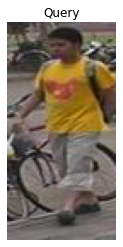

['014620.jpg', '017485.jpg', '001356.jpg', '003809.jpg', '007046.jpg', '006256.jpg', '017430.jpg', '012083.jpg', '010287.jpg', '004231.jpg', '011274.jpg', '015038.jpg', '000487.jpg', '015254.jpg', '012063.jpg']


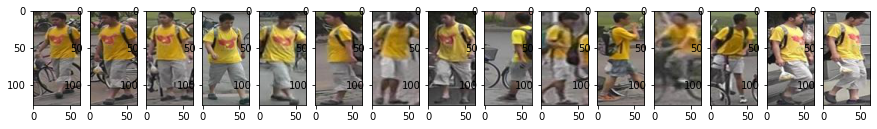

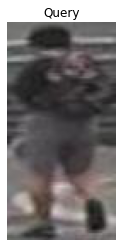

['007004.jpg', '000807.jpg', '004630.jpg', '006108.jpg', '003652.jpg', '003305.jpg', '017720.jpg', '019145.jpg', '016009.jpg', '001792.jpg', '007676.jpg', '015648.jpg', '019247.jpg', '012762.jpg', '001796.jpg']


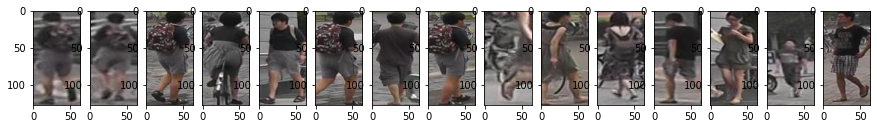

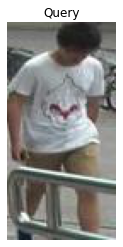

['009969.jpg', '017214.jpg', '006842.jpg', '013168.jpg', '014724.jpg', '011860.jpg', '017052.jpg', '000993.jpg', '009592.jpg', '011808.jpg', '000498.jpg', '002856.jpg', '012092.jpg', '005755.jpg', '001965.jpg']


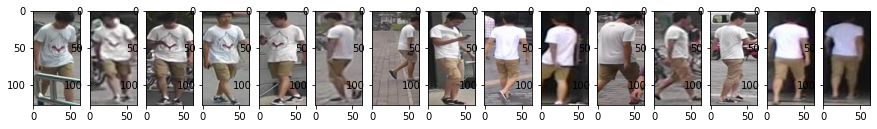

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import random

for i in range(3):
  img_idx = random.randint(0, len(queries_images_list))
  im = Image.open(os.path.join(config["queries_root"], queries_images_list[img_idx]))
  plt.imshow(im)
  plt.axis('off')
  plt.title('Query')
  plt.show()

  results = submission_id_dict[queries_images_list[img_idx]].split(", ")
  print(results)
  imgs = [Image.open(os.path.join(config["test_root"], r)) for r in results]
  _, axs = plt.subplots(1, 15, figsize=(15, 15))
  axs = axs.flatten()
  for img, ax in zip(imgs, axs):
      ax.imshow(img)
  plt.show()

### Attributes submission

In [21]:
def predict_attributes_for_test(model, loader):
    model.eval()

    all_predictions = np.empty(shape=[0, 27], dtype=np.byte)

    with torch.no_grad():
        for batch_idx, (inputs, _, _) in enumerate(tqdm(loader)):
                inputs = inputs.to(device)
                outputs, _, _ = model(inputs)
                predictions = torch.empty(27, inputs.size()[0])
                for attr_idx, output in enumerate(outputs):
                    if output.size()[1] == 1: #If the output is binary
                        pred = torch.round(torch.squeeze(output, 1))
                    else: #Otherwise it is 
                        pred = torch.argmax(output, dim=1)
                    predictions[attr_idx] = pred
                predictions = torch.transpose(predictions, 0, 1).cpu().numpy()
                all_predictions = np.append(all_predictions, predictions, axis=0)
        return all_predictions
  
attributes = predict_attributes_for_test(model, test_loader)

In [22]:
import pandas as pd

classification_submission_file = "classification_test.csv"
attr_dataframe = pd.DataFrame(data=attributes.astype(int),    # values
                              index=test_images_list,    # 1st column as index
                              columns=["age","backpack","bag","handbag","clothes","down","up","hair","hat","gender","upblack","upwhite","upred","uppurple","upyellow","upgray","upblue","upgreen","downblack","downwhite","downpink","downpurple","downyellow","downgray","downblue","downgreen","downbrown"])

csv = attr_dataframe.to_csv(index=True)
f = open(classification_submission_file,"w")
f.write(csv)
f.close()